In [17]:
!pip install autokeras

In [18]:
# Import the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
import autokeras as ak

In [19]:
# Load dataset
trainSet = pd.read_csv('/home/nick/smartjournal-AI/emotion-labels-train.csv')
valSet = pd.read_csv('/home/nick/smartjournal-AI/emotion-labels-test.csv')
testSet = pd.read_csv('/home/nick/smartjournal-AI/emotion-labels-val.csv')
trainSet.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [20]:
# This dataset splits the training and validation datasets in the beginning.
# This notebook combines the training and validation datasets together and split them again according to randomness.
# The validation dataset is 20% of the total dataset
train = pd.concat([trainSet, valSet], axis=0).reset_index(drop=True)

# Split data
X_train, X_val, y_train, y_val = train_test_split(train['text'], train['label'],
                                                    stratify=train['label'],
                                                    test_size=0.2, random_state=123)

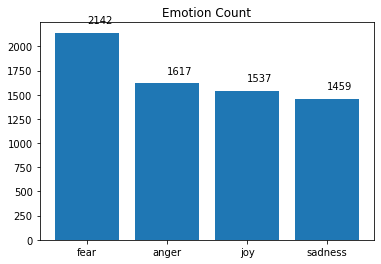

In [21]:
plt.bar(train['label'].value_counts().index, list(train['label'].value_counts()))
for index, value in enumerate(list(train['label'].value_counts())):
    plt.text(index, value+100, str(value))
plt.title('Emotion Count')
plt.show()

In [22]:
print('Number of training data observations ' + str(train.shape[0]))

Number of training data observations 6755


In [23]:
# Preparing the data for autokeras
X_train_ak = np.array(X_train)
y_train_ak = np.array(y_train)
X_val_ak = np.array(X_val)
y_val_ak = np.array(y_val)

In [24]:
# Create the model
node_input = ak.TextInput()
node_output = ak.TextToIntSequence()(node_input)
node_output = ak.Embedding()(node_output)
node_output = ak.ConvBlock(separable=True)(node_output)
node_output = ak.ClassificationHead()(node_output)
keras = ak.AutoModel(inputs=node_input, outputs=node_output, overwrite=True, max_trials=3)

# Fit the training dataset
keras.fit(X_train_ak, y_train_ak, epochs=80, validation_split=0.2)

Trial 3 Complete [00h 01m 23s]
val_loss: 0.8150273561477661

Best val_loss So Far: 0.7833824753761292
Total elapsed time: 00h 03m 52s
INFO:tensorflow:Oracle triggered exit
Epoch 1/80
169/169 [==============================] - 5s 23ms/step - loss: 1.3779 - accuracy: 0.3168
Epoch 2/80
169/169 [==============================] - 4s 23ms/step - loss: 1.3747 - accuracy: 0.3172
Epoch 3/80
169/169 [==============================] - 4s 23ms/step - loss: 1.3695 - accuracy: 0.3224
Epoch 4/80
169/169 [==============================] - 4s 23ms/step - loss: 1.1328 - accuracy: 0.4671
Epoch 5/80
169/169 [==============================] - 4s 23ms/step - loss: 0.8488 - accuracy: 0.6134
Epoch 6/80
169/169 [==============================] - 4s 24ms/step - loss: 0.6566 - accuracy: 0.7372
Epoch 7/80
169/169 [==============================] - 4s 25ms/step - loss: 0.5092 - accuracy: 0.8161
Epoch 8/80
169/169 [==============================] - 4s 23ms/step - loss: 0.3743 - accuracy: 0.8768
Epoch 9/80
169/169 [

2022-03-16 02:43:21.644326: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [25]:
# Show the built models
keras_export = keras.export_model()
keras_export.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 expand_last_dim (ExpandLast  (None, 1)                0         
 Dim)                                                            
                                                                 
 text_vectorization (TextVec  (None, 64)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 64, 128)           2560128   
                                                                 
 dropout (Dropout)           (None, 64, 128)           0         
                                                                 
 separable_conv1d (Separable  (None, 60, 32)           4768  

In [26]:
# Predict the validation data
pred_keras = keras.predict(X_val_ak)

# Compute the accuracy
print('Accuracy: ' + str(accuracy_score(y_val_ak, pred_keras)))

43/43 [==============================] - 0s 8ms/step
Accuracy: 0.7387120651369357


In [27]:
# Convert predicted result into pandas series with numeric type
pred_keras_ = pd.DataFrame(pred_keras)
pred_keras_ = pred_keras_[0]

# Compute the accuracy
print('Accuracy: ' + str(accuracy_score(y_val, pred_keras_)))
print('')

# Prediction results
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_val, pred_keras_), index=['anger','fear','joy','sad'], columns=['anger','fear','joy','sad']))
print('')
print('Classification Report')
print(classification_report(y_val, pred_keras_))

Accuracy: 0.7387120651369357

Confusion Matrix
       anger  fear  joy  sad
anger    219    22   49   33
fear       8   322   57   41
joy       24    28  235   21
sad       21    22   27  222

Classification Report
              precision    recall  f1-score   support

       anger       0.81      0.68      0.74       323
        fear       0.82      0.75      0.78       428
         joy       0.64      0.76      0.70       308
     sadness       0.70      0.76      0.73       292

    accuracy                           0.74      1351
   macro avg       0.74      0.74      0.74      1351
weighted avg       0.75      0.74      0.74      1351

